In [10]:
import math
import torch
import gpytorch
import numpy as np
from scipy import *
from BlackScholes import *
from matplotlib import pyplot as plt
from scipy import stats  

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### set BS model parameters

In [132]:
r = 0.0  # risk-free rate
S= 100      # Underlying spot
KC = 110    # Call strike
KP = 90     # Put strike
sigma = 0.3 # implied volatility
T = 2.0     # Time to maturity

In [11]:
# define the call and put prices using the BS model
call = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]
put = lambda x: bsformula(-1, lb+(ub-lb)*x, KP, r, T, sigma, 0)[0]

In [445]:
lb = 0.001           # lower bound on domain
ub = 300             # upper bound on domain
training_number = 5 # Number of training samples
testing_number = 100 # Number of testing samples

train_x = torch.linspace(0, 1.0, training_number)
wn_variances = 0.001*torch.randn(training_number)

train_y1 = torch.FloatTensor(call(np.array(train_x)))
train_y2 = torch.FloatTensor(put(np.array(train_x)))

#Create a train_y which interleaves the two
train_y = torch.stack([train_y1, train_y2], -1)

## define multi-GP class

In [446]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        
        self.covar_module = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)+ gpytorch.kernels.WhiteNoiseKernel(wn_variances)), 
                                                             num_tasks=2, rank=1
        )
              
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [312]:
test_x = torch.linspace(0, 1.0, testing_number)
test_y1 = torch.FloatTensor(call(np.array(test_x)))
test_y2 = torch.FloatTensor(put(np.array(test_x)))
test_y = torch.stack([test_y1, test_y2], -1)

In [447]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 300
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f lengthscale: %.3f' % (i + 1, n_iter, loss.item(), model.covar_module.data_covar_module.base_kernel.kernels[0].lengthscale))
    
    optimizer.step()

Iter 1/300 - Loss: 4170.101 lengthscale: 0.693
Iter 2/300 - Loss: 3593.674 lengthscale: 0.644
Iter 3/300 - Loss: 3115.783 lengthscale: 0.599
Iter 4/300 - Loss: 2720.292 lengthscale: 0.556
Iter 5/300 - Loss: 2392.853 lengthscale: 0.516
Iter 6/300 - Loss: 2119.866 lengthscale: 0.480
Iter 7/300 - Loss: 1891.150 lengthscale: 0.447
Iter 8/300 - Loss: 1698.799 lengthscale: 0.417
Iter 9/300 - Loss: 1535.788 lengthscale: 0.390
Iter 10/300 - Loss: 1397.036 lengthscale: 0.367
Iter 11/300 - Loss: 1278.547 lengthscale: 0.346
Iter 12/300 - Loss: 1176.339 lengthscale: 0.329
Iter 13/300 - Loss: 1087.398 lengthscale: 0.313
Iter 14/300 - Loss: 1010.501 lengthscale: 0.301
Iter 15/300 - Loss: 942.722 lengthscale: 0.290
Iter 16/300 - Loss: 882.737 lengthscale: 0.281
Iter 17/300 - Loss: 829.313 lengthscale: 0.274
Iter 18/300 - Loss: 782.059 lengthscale: 0.268
Iter 19/300 - Loss: 739.263 lengthscale: 0.264
Iter 20/300 - Loss: 701.112 lengthscale: 0.260
Iter 21/300 - Loss: 666.399 lengthscale: 0.258
Iter 22/

Iter 176/300 - Loss: 131.031 lengthscale: 0.234
Iter 177/300 - Loss: 130.489 lengthscale: 0.233
Iter 178/300 - Loss: 130.414 lengthscale: 0.233
Iter 179/300 - Loss: 129.308 lengthscale: 0.233
Iter 180/300 - Loss: 128.761 lengthscale: 0.233
Iter 181/300 - Loss: 128.603 lengthscale: 0.233
Iter 182/300 - Loss: 127.822 lengthscale: 0.233
Iter 183/300 - Loss: 127.905 lengthscale: 0.232
Iter 184/300 - Loss: 126.914 lengthscale: 0.232
Iter 185/300 - Loss: 126.546 lengthscale: 0.232
Iter 186/300 - Loss: 126.148 lengthscale: 0.232
Iter 187/300 - Loss: 125.488 lengthscale: 0.232
Iter 188/300 - Loss: 124.586 lengthscale: 0.232
Iter 189/300 - Loss: 124.413 lengthscale: 0.232
Iter 190/300 - Loss: 124.288 lengthscale: 0.231
Iter 191/300 - Loss: 123.709 lengthscale: 0.231
Iter 192/300 - Loss: 123.104 lengthscale: 0.231
Iter 193/300 - Loss: 122.768 lengthscale: 0.231
Iter 194/300 - Loss: 122.318 lengthscale: 0.231
Iter 195/300 - Loss: 121.987 lengthscale: 0.231
Iter 196/300 - Loss: 121.047 lengthscale

In [449]:
# Make predictions
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    y_hat= likelihood(model(test_x))
lower, upper = y_hat.confidence_region()

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/gpytorch/kernels/kernel.py:278: UserWarning: You are using a version of PyTorch where torch.pdist does not support batch matrices. Falling back on manual distance computation. Updating PyTorch to the latest pytorch-nightly build will offer significant memory savings during kernel computation.
  warnings.warn('You are using a version of PyTorch where torch.pdist does not support batch '


In [451]:
# Print fitted parameters
a = model.covar_module.task_covar_module.covar_factor.clone().detach()
v = model.covar_module.task_covar_module.var.clone().detach()
Omega = np.outer(a,a) + np.diag(v)
#lengthscale=model.covar_module.data_covar_module.lengthscale
lengthscale=model.covar_module.data_covar_module.base_kernel.kernels[0].lengthscale
nu=model.covar_module.data_covar_module.base_kernel.kernels[0].nu
print(lengthscale, nu, Omega)

tensor([[[0.2196]]], grad_fn=<ClampBackward>) 2.5 [[40.941822    0.37789273]
 [ 0.37789273  3.7487829 ]]


Text(0,0.5,'$\\pi$')

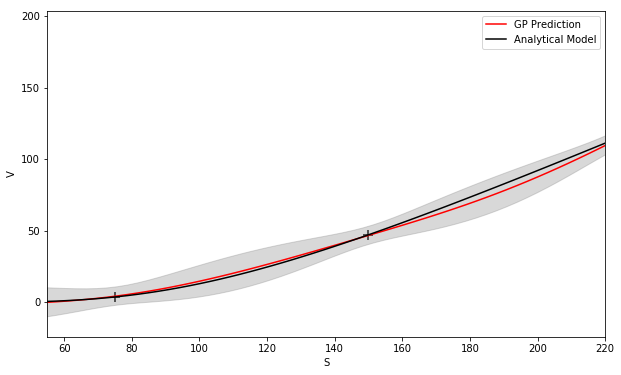

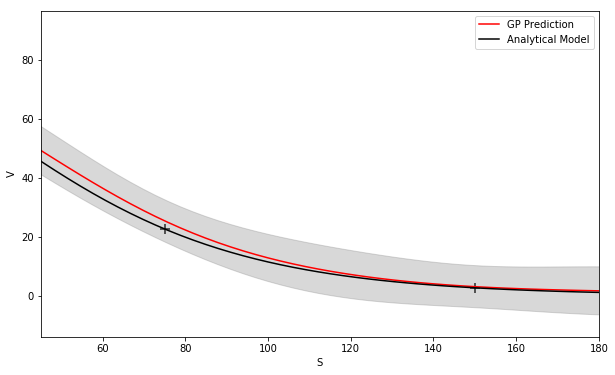

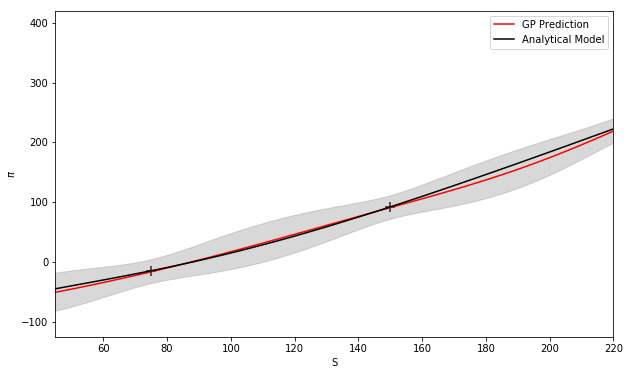

In [452]:
# predictionn plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,0]), color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y[:,0]), color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x, train_y[:,0], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,0].detach().numpy(), upper[:,0].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KC/2.0,2*KC])
plt.xlabel('S')
plt.ylabel('V')


plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,1]), color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y[:,1]), color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x, train_y[:,1], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,1].detach().numpy(), upper[:,1].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KP/2.0,2*KP])
plt.xlabel('S')
plt.ylabel('V')


plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), 2.0*np.array(y_hat.mean[:,0])- np.array(y_hat.mean[:,1]), color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), 2.0*np.array(test_y[:,0])-np.array(test_y[:,1]) , color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x, 2*train_y[:,0]-train_y[:,1], color = 'black', marker = '+', s = 100) 

plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), 2.0*lower[:,0].detach().numpy()-upper[:,1].detach().numpy() , 2.0*upper[:,0].detach().numpy()-lower[:,1].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KP/2.0,2*KC])
plt.xlabel('S')
plt.ylabel('$\pi$')

In [ ]:
# covariance of posterior
var_1=np.diag(np.array(y_hat.covariance_matrix.detach().numpy()),0)[0:199:2]
var_2=np.diag(np.array(y_hat.covariance_matrix.detach().numpy()),0)[1:199:2]
covar_12=np.diag(np.array(y_hat.covariance_matrix.detach().numpy()),1)[0:199:2]

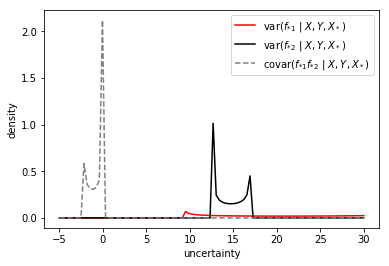

In [463]:
lnspc = np.linspace(-5.0, 30, 100)

ab,bb,cb,db = stats.beta.fit(var_1)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='var($f_{*1}$ $\|$ $X,Y,X_*$)', color='r')

ab,bb,cb,db = stats.beta.fit(var_2)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='var($f_{*2}$ $\|$ $X,Y,X_*$)', color='k')

ab,bb,cb,db = stats.beta.fit(covar_12)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='covar($f_{*1}f_{*2}$ $\|$ $X,Y,X_*$)', color="grey", linestyle='--')

#ab,bb,cb,db = stats.beta.fit(CVA_1_yr_tilde_down-CVA_tilde_down)  
#pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
#plt.plot(lnspc, pdf_beta, label='MC-GP (upper)', color='grey', linestyle='-.')

plt.xlabel('uncertainty')
plt.ylabel('density')
plt.legend()
plt.show()